## Data To Coup

In [99]:
import sys
print (sys)

<module 'sys' (built-in)>


In [100]:
import pandas as pd
import matplotlib.axes as ax
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [101]:
# Loading the necessary csv files
coup = pd.read_csv("../assets/csv/Coups.csv")
stab = pd.read_csv("../assets/csv/Politicalinstability2.csv")
polity = pd.read_csv("../assets/csv/polity.csv")
leaders = pd.read_csv("../assets/csv/leaders.csv")
urban = pd.read_csv("../assets/csv/urbanpop.csv")
gdp = pd.read_csv("../assets/csv/Realpercapitagdp.csv")
growth = pd.read_csv("../assets/csv/GDPgrowth.csv")

In [102]:
# Summing scoup1(successful coups) and acoup1(attempted coups) to generate sumcoup
# I want a columns with binary variables that indicates coup (successful and attempted) or no coup
coup["sumcoup"] = coup["scoup1"] + coup["atcoup2"]

# To make a bianary column
coupbin = []
for i in coup["sumcoup"].tolist():
    if i > 0:
        coupbin.append(1)
    if i == 0:
        coupbin.append(0)
coup["Coup"] = coupbin

In [103]:
# Dropping unnecessary columns
coup.drop(["scoup1", "atcoup2", "sumcoup"], axis=1, inplace=True)

In [104]:
# To covert the variables in PTYPE to dummy variables 
dummies = pd.get_dummies(stab["PTYPE"])
stab = stab[["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
             "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT"]].join(dummies)

stab.columns = ["COUNTRY", "YEAR", "GENDEATHMAG", "ETHMAGFATAL", 
                "ETHMAGFIGHT", "REVMAGFATAL", "REVMAGFIGHT", "NONE",
                "ETH", "REV", "GEN"]

In [105]:
# To avoid repetition of rows, I want to group the dataframes bq
aggMap = { "NONE" : "max", "ETH" : "max", "REV" : "max", 
           "GEN" : "max", "GENDEATHMAG" : "max", 
           "ETHMAGFATAL" : "max", "ETHMAGFIGHT" : "max", 
           "REVMAGFATAL" : "max", "REVMAGFIGHT" : "max" }

stabGrouped = stab.groupby(["COUNTRY","YEAR"]).agg(aggMap).reset_index()

In [106]:
# Joining the political stabilty and coup tables 
coup1 = coup.merge(stabGrouped, how="inner", left_on=["country", "year"], right_on=["COUNTRY", "YEAR"])

In [107]:
# Dropping the unnecessary columns and setting all columns to lower case for easier manipulation in the future
coup1.drop(["COUNTRY", "YEAR"], axis=1, inplace=True)
coup1.columns = map(str.lower, coup1.columns)

In [108]:
# Dropping unnecessary variables
polity.drop(["flag", "fragment", "democ", "autoc", "polity"], axis=1, inplace=True)

In [109]:
# Merging polity table with coup1 table
coup2 = coup1.merge(polity, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [110]:
# Merging coup2 and leaders
coup3 = coup2.merge(leaders, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [111]:
# I want to change the shape of the table, so the year columns become rows
Col1 = urban.columns[0]
Col2 = urban.columns[1:].tolist()
urban1 = pd.melt(urban, id_vars=(Col1), var_name="year", value_vars=(Col2), value_name="urbanpop")
urban1.sort_values(["country", "year"], inplace=True)

In [112]:
# Also changing the shape of the table here
Col3 = gdp.columns[0]
Col4 = gdp.columns[1:].tolist()
gdp1 = pd.melt(gdp, id_vars=(Col3), var_name="year", value_vars=(Col4), value_name="gdppercap")
gdp1.sort_values(["country", "year"], inplace=True)

In [113]:
# Cleaning the values in the gdp1 table
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace('$', '')
gdp1['gdppercap'] = gdp1['gdppercap'].str.replace(',', '')

In [114]:
# Coverting the values to numeric
gdp1['gdppercap'] = gdp1['gdppercap'].convert_objects(convert_numeric=True)
gdp1.dtypes

/Users/airbr/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdppercap    float64
dtype: object

In [115]:
# Changing the shape of the table
Col5 = growth.columns[0]
Col6 = growth.columns[1:].tolist()
growth1 = pd.melt(growth, id_vars=(Col5), var_name="year", value_vars=(Col6), value_name="gdpgrowth")
growth1.sort_values(["country", "year"], inplace=True)

In [116]:
# Converting to numeric
growth1['gdpgrowth'] = growth1['gdpgrowth'].convert_objects(convert_numeric=True)
growth1.dtypes

/Users/airbr/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


country       object
year          object
gdpgrowth    float64
dtype: object

In [117]:
# Joining tables again
Econ = gdp1.merge(growth1, how="inner", left_on=["country", "year"], right_on=["country", "year"])
Econ1 = Econ.merge(urban1, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [118]:
# Convert the year column to numeric
Econ1["year"] = Econ1["year"].convert_objects(convert_numeric=True)

/Users/airbr/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [119]:
# Final join!
DF = Econ1.merge(coup3, how="inner", left_on=["country", "year"], right_on=["country", "year"])

In [120]:
# Incorporating a new table into the dataframe
# Importing the csv file as a list of lists
# Converting the list to a data dictionary, with the countries being the keys and ethinic, linguistic, and religious
# fractionalization respectively serving as the values
path = "../assets/csv/diversity.csv"
import csv

def read_file(path):
    with open(path, 'r') as f:
        diversity = [row for row in csv.reader(f.read().splitlines())]
    return diversity

diversity = read_file(path)
diversity = diversity[1:]
#print diversity

def function(i):return (i[0], i[1:])
div_dict = map(function, diversity)
divDict = dict(div_dict)

In [121]:
# Matching the values from the dictionary to their respective countries
loc = DF["country"].tolist()


ethnicity = []
linguistic = []
religious = []


for i in loc:
    for country, ethnic in divDict.items():
        if i == country:
            ethnicity.append( ethnic[0] )
            linguistic.append( ethnic[1] )
            religious.append( ethnic[2] )

In [122]:
#Assigning these values to their respective columns
DF["ethnic"] = ethnicity
DF["linguistic"] = linguistic
DF["religious"] = religious

In [123]:
# Drop rows with missing values (since they are relatively few)
# Drop the year columns since I won't be needing it for my analysis
DF.dropna(axis=0, how="any", inplace=True)
DF.drop(["year"], axis=1, inplace=True)

In [124]:
# Converting year column to numeric
DF[["ethnic", "linguistic", "religious"]] = DF[["ethnic", "linguistic", "religious"]] \
                                            .convert_objects(convert_numeric=True)

/Users/airbr/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [125]:
# Removing more missing values
DF = DF[DF.ethmagfatal != 9]
DF = DF[DF.ethmagfight != 9]
DF = DF[DF.revmagfatal != 9]
DF = DF[DF.revmagfight != 9]

<h1>Data Dictionary</h1>


Variable|Description|Data Type|Variable Type
--|--
country|Country Name|Object|Unique
coup|1 = Coup(successful and attempted), 0 = No coup|Integer|Binary
gdppercap|GDP per capita|Float|Continuous 
gdpgrowth|GDP growth rate|Float|Continuous
urbanpop|Percentage of urban population|Float|Continuous
gendeathmag|Scaled annual number of deaths (range 0-5.0)|Float|Categorical Ordinal
revmagfight|Scaled annual number of fatalities related to revolutionary fighting (range 0-4)|Integer|Categorical Ordinal
ethmagfatal|Scaled annual number of fatalities related to ethnic fighting (range 0-4)|Integer|Categorical Ordinal
revmagfatal|Scaled number of rebel combatants or activists in revolutionary war (range 0-4)|Integer|Categorical Ordinal
ethmagfight|Scaled number of rebel combatants or activists in ethnic war (range 0-4)|Integer|Categorical Ordinal
polity2|Polity scale ranging from +10 (strongly democratic) to -10 (strongly autocratic)|Integer|Categorical Non-Ordinal
durable|Regime durabilty: the number of years since the most recent regime|Float|Categorical Ordinal
yip|Number of years head of state has been in power|Integer|Continuous
none|No violence occured|Float|Binary
eth|Indicates the occurence of an ethnic violence|Float|Binary
rev|Indicates the occurence of a revolutionary violence|Float|Binary
gen|Indicates the occurence of a genocide|Float|Binary
ethnic| Ethnic Fractionalization|Float|Continuous
linguistic|Linguistic Fractionalization|Float|Continuous
religious| Religious Fractionalization|Float|Continuous

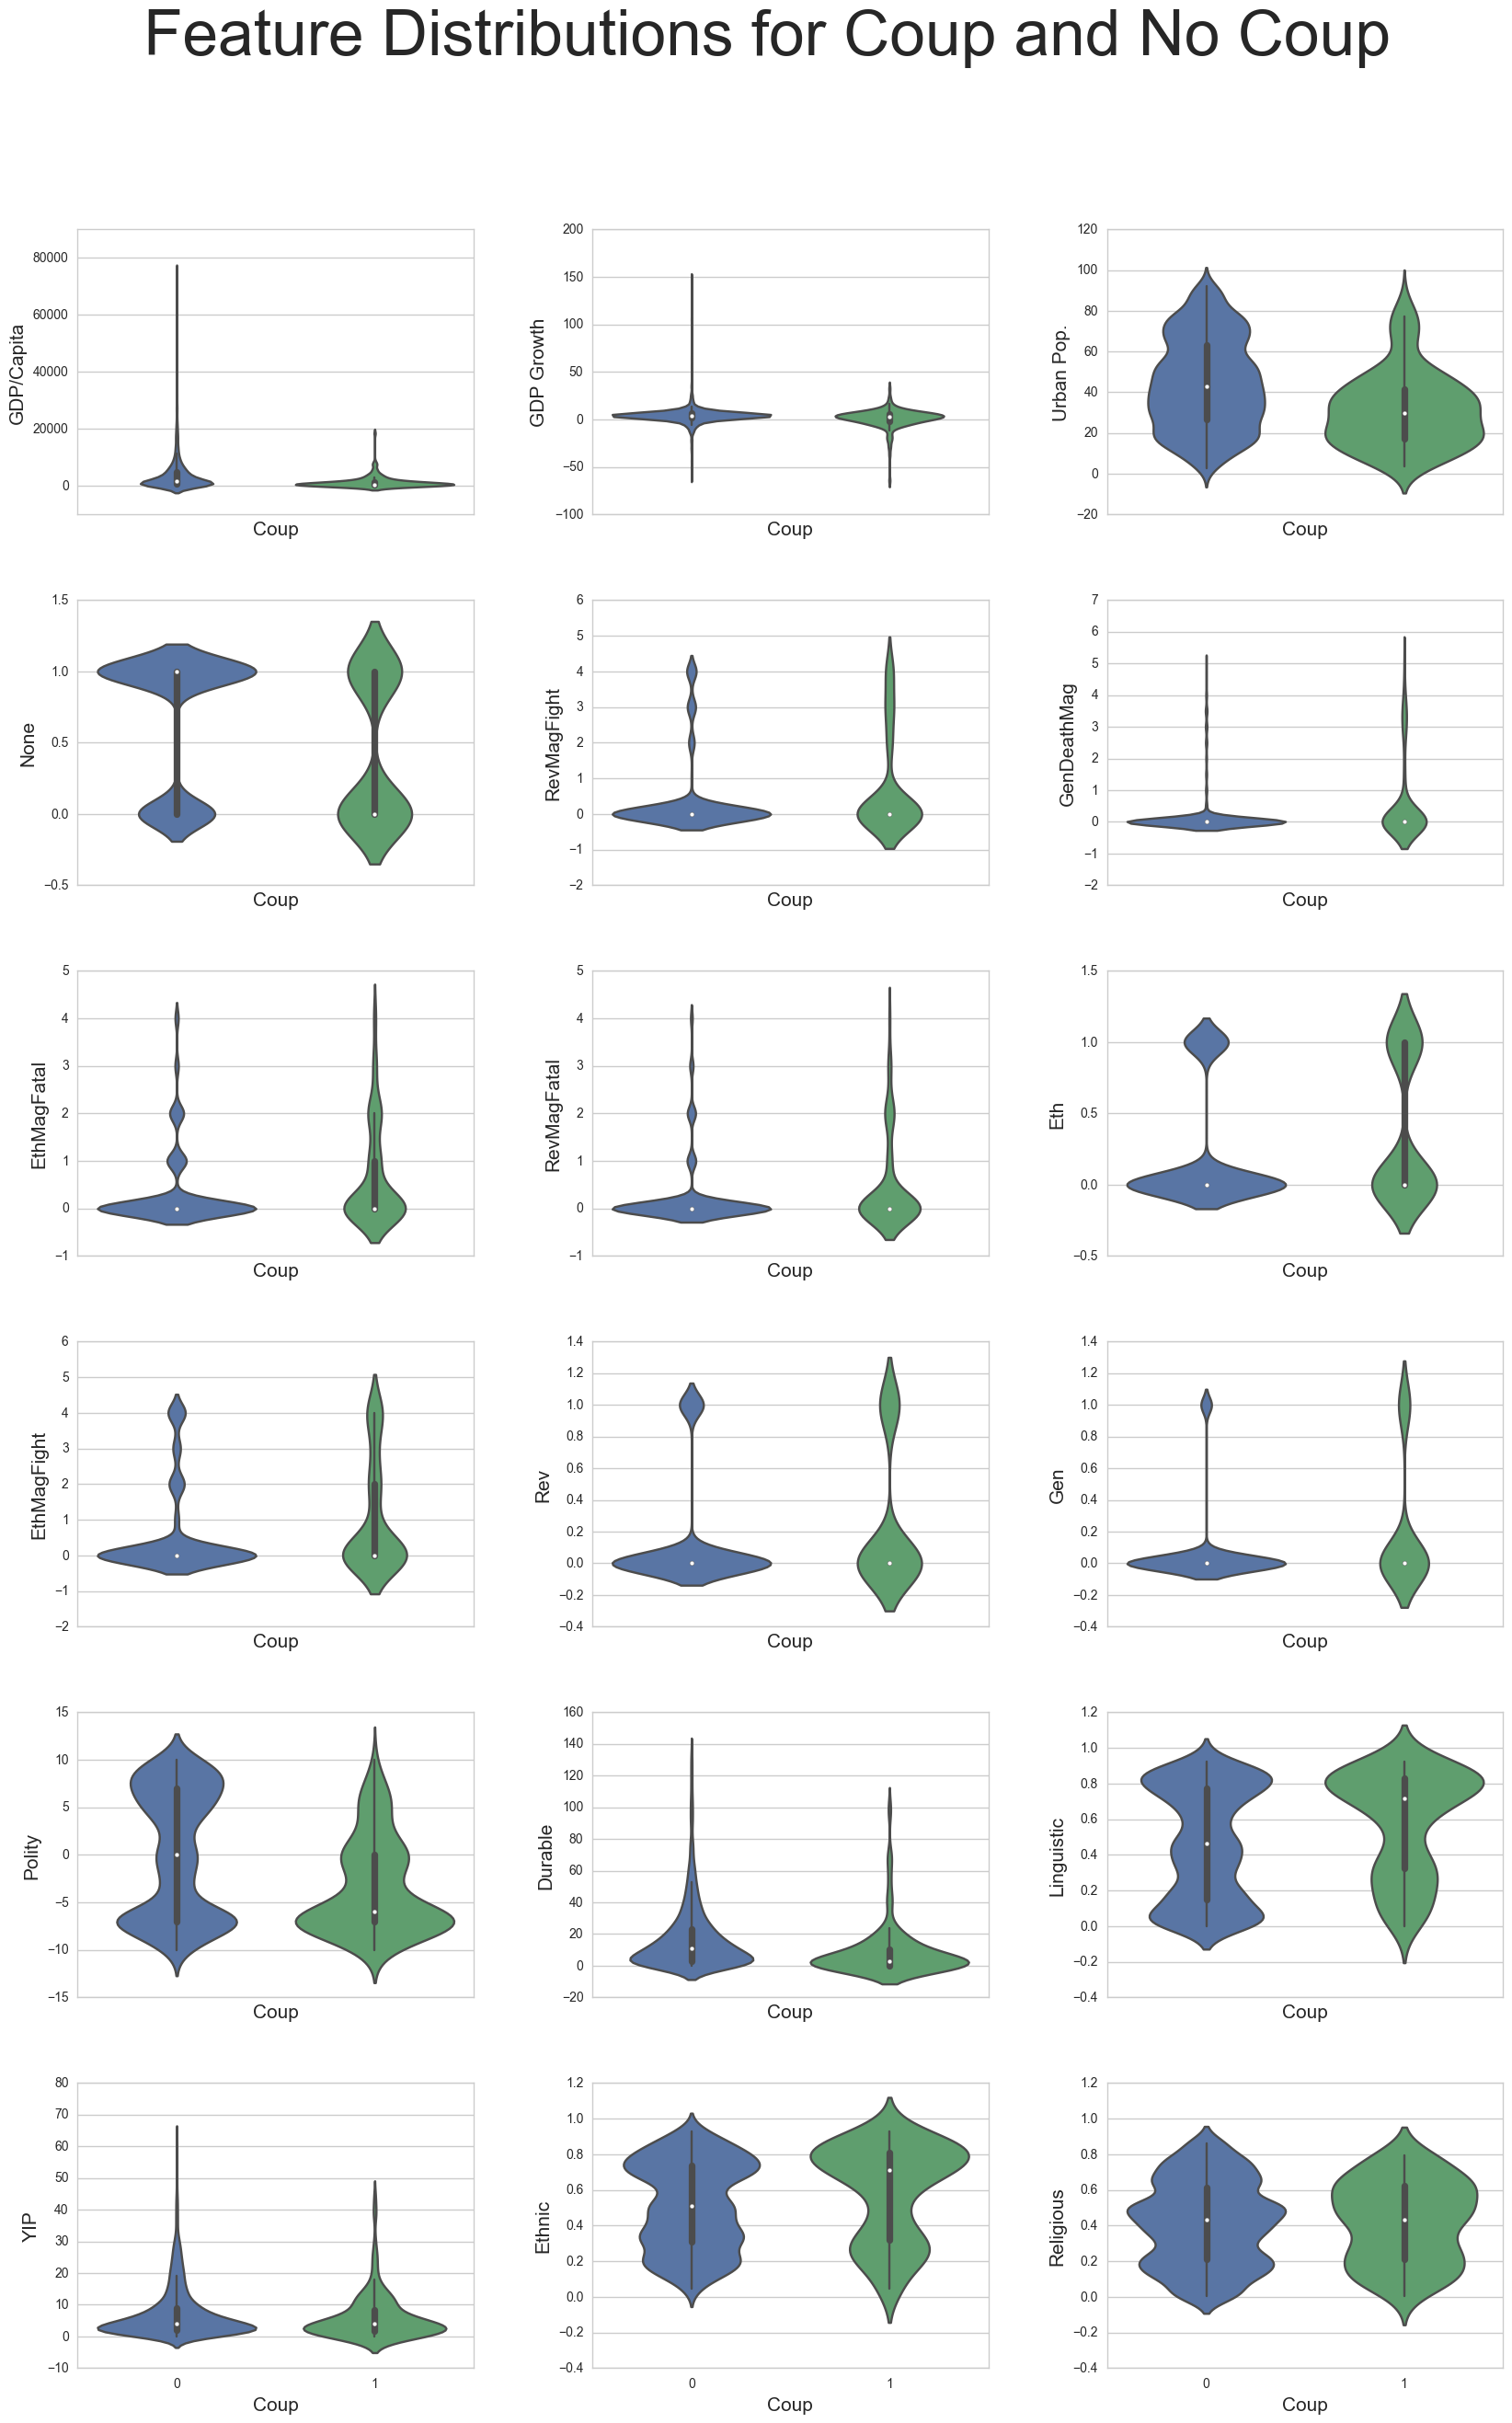

In [126]:
# To observe the differences in distribution of feactures for coup and no coup
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), \
      (ax13, ax14, ax15), (ax16, ax17, ax18)) = plt.subplots(nrows=6, ncols=3, \
        sharey=False, sharex=True, figsize=(20,30))
fig.suptitle("Feature Distributions for Coup and No Coup", size=50)

sns.set_style("whitegrid")
sns.violinplot(x='coup', y="gdppercap", data=DF, ax=ax1)
ax1.set_xlabel("Coup", fontsize=15)
ax1.set_ylabel("GDP/Capita", fontsize=15)  
    
sns.violinplot(x='coup', y="gdpgrowth", data=DF, ax=ax2)
ax2.set_xlabel("Coup", fontsize=15)
ax2.set_ylabel("GDP Growth", fontsize=15)

sns.violinplot(x='coup', y="urbanpop", data=DF, ax=ax3)
ax3.set_xlabel("Coup", fontsize=15)
ax3.set_ylabel("Urban Pop.", fontsize=15)

sns.violinplot(x='coup', y="none", data=DF, ax=ax4)
ax4.set_xlabel("Coup", fontsize=15)
ax4.set_ylabel("None", fontsize=15)

sns.violinplot(x='coup', y="revmagfight", data=DF, ax=ax5)
ax5.set_xlabel("Coup", fontsize=15)
ax5.set_ylabel("RevMagFight", fontsize=15)

sns.violinplot(x='coup', y="gendeathmag", data=DF, ax=ax6)
ax6.set_xlabel("Coup", fontsize=15)
ax6.set_ylabel("GenDeathMag", fontsize=15)

sns.violinplot(x='coup', y="ethmagfatal", data=DF, ax=ax7)
ax7.set_xlabel("Coup", fontsize=15)
ax7.set_ylabel("EthMagFatal", fontsize=15)

sns.violinplot(x='coup', y="revmagfatal", data=DF, ax=ax8)
ax8.set_xlabel("Coup", fontsize=15)
ax8.set_ylabel("RevMagFatal", fontsize=15)

sns.violinplot(x='coup', y="eth", data=DF, ax=ax9)
ax9.set_xlabel("Coup", fontsize=15)
ax9.set_ylabel("Eth", fontsize=15)

sns.violinplot(x='coup', y="ethmagfight", data=DF, ax=ax10)
ax10.set_xlabel("Coup", fontsize=15)
ax10.set_ylabel("EthMagFight", fontsize=15)

sns.violinplot(x='coup', y="rev", data=DF, ax=ax11)
ax11.set_xlabel("Coup", fontsize=15)
ax11.set_ylabel("Rev", fontsize=15)

sns.violinplot(x='coup', y="gen", data=DF, ax=ax12)
ax12.set_xlabel("Coup", fontsize=15)
ax12.set_ylabel("Gen", fontsize=15)

sns.violinplot(x='coup', y="polity2", data=DF, ax=ax13)
ax13.set_xlabel("Coup", fontsize=15)
ax13.set_ylabel("Polity", fontsize=15)

sns.violinplot(x='coup', y="durable", data=DF, ax=ax14)
ax14.set_xlabel("Coup", fontsize=15)
ax14.set_ylabel("Durable", fontsize=15)

sns.violinplot(x='coup', y="linguistic", data=DF, ax=ax15)
ax15.set_xlabel("Coup", fontsize=15)
ax15.set_ylabel("Linguistic", fontsize=15)

sns.violinplot(x='coup', y="yip", data=DF, ax=ax16)
ax16.set_xlabel("Coup", fontsize=15)
ax16.set_ylabel("YIP", fontsize=15)

sns.violinplot(x='coup', y="ethnic", data=DF, ax=ax17)
ax17.set_xlabel("Coup", fontsize=15)
ax17.set_ylabel("Ethnic", fontsize=15)

sns.violinplot(x='coup', y="religious", data=DF, ax=ax18)
ax18.set_xlabel("Coup", fontsize=15)
ax18.set_ylabel("Religious", fontsize=15)

fig.subplots_adjust(hspace=.3, wspace=.3)

In [127]:
# To split the dataframe into one with instances of a coup and another with instances of no coup
acoup = DF.loc[DF.coup==1]
nocoup = DF.loc[DF.coup==0]

In [128]:
# To test for statistical differences in the means of features for coup and no coup
features = ["gdppercap", "gdpgrowth", "urbanpop", "none", "revmagfight", 
            "gendeathmag", "ethmagfatal", "revmagfatal", "eth", 
            "ethmagfight", "rev", "gen", "polity2", "durable", 
            "yip", "ethnic", "linguistic", "religious"]

for i in features:
    print (ttest_ind(acoup[i], nocoup[i]))

Ttest_indResult(statistic=-5.903224986748083, pvalue=3.9645881653056079e-09)
Ttest_indResult(statistic=-4.3331123490262344, pvalue=1.5185460388038557e-05)
Ttest_indResult(statistic=-7.4955360422797614, pvalue=8.6454743932737962e-14)
Ttest_indResult(statistic=-6.9963312047619572, pvalue=3.2284016691127165e-12)
Ttest_indResult(statistic=3.673156595854902, pvalue=0.00024376570626343473)
Ttest_indResult(statistic=6.8551901674524931, pvalue=8.6138153215874287e-12)
Ttest_indResult(statistic=4.2110417871282175, pvalue=2.616882791040803e-05)
Ttest_indResult(statistic=4.0172147164868059, pvalue=6.0338695171472901e-05)
Ttest_indResult(statistic=4.3131641771123963, pvalue=1.6613753228986777e-05)
Ttest_indResult(statistic=3.9637847222136715, pvalue=7.5494942217101615e-05)
Ttest_indResult(statistic=3.8759171428801622, pvalue=0.00010850312964861792)
Ttest_indResult(statistic=6.4820650003824429, pvalue=1.0542806733368283e-10)
Ttest_indResult(statistic=-7.1351177353848811, pvalue=1.2078499194544278e-1

## Data Exploration

In [129]:
gBPolity = DF.groupby("polity2").mean()
gBPolity

,gdppercap,gdpgrowth,urbanpop,coup,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,durable,yip,ethnic,linguistic,religious
polity2,,,,,,,,,,,,,,,,,,
-10,9190.000000,8.205625,46.028750,0.031250,0.718750,0.625000,0.000000,0.000000,0.281250,0.000000,0.000000,0.281250,0.000000,21.250000,11.187500,0.509519,0.478419,0.333137
-9,2794.603015,4.041759,41.236131,0.080402,0.778894,0.065327,0.153266,0.206030,0.055276,0.160804,0.502513,0.030151,0.065327,24.070352,13.361809,0.534673,0.480890,0.408848
-8,3810.839623,4.242264,44.474434,0.047170,0.594340,0.613208,0.330189,0.320755,0.415094,0.207547,0.716981,0.216981,0.094340,22.094340,12.745283,0.547953,0.473160,0.354853
-7,2033.178631,4.345977,35.465860,0.105175,0.706177,0.262104,0.381469,0.388982,0.171953,0.205342,0.587646,0.076795,0.161937,19.547579,7.634391,0.573607,0.465149,0.431636
-6,3021.279570,4.877527,41.552527,0.059140,0.731183,0.462366,0.129032,0.204301,0.220430,0.107527,0.263441,0.155914,0.086022,26.301075,8.849462,0.506697,0.470518,0.310522
-5,1839.148148,4.000185,29.843704,0.092593,0.481481,0.796296,0.092593,0.592593,0.425926,0.444444,1.111111,0.222222,0.074074,9.851852,6.796296,0.509685,0.439667,0.393644
-4,1139.538462,3.460192,27.925192,0.134615,0.346154,0.365385,0.278846,0.826923,0.134615,0.576923,1.365385,0.096154,0.115385,8.596154,9.461538,0.564892,0.526631,0.467673
-3,2625.329545,4.565114,39.977273,0.045455,0.579545,0.511364,0.170455,0.409091,0.386364,0.295455,0.772727,0.193182,0.056818,6.000000,8.261364,0.468400,0.339227,0.356615
-2,2245.196721,4.367541,29.626393,0.098361,0.704918,0.704918,0.163934,0.163934,0.377049,0.098361,0.278689,0.245902,0.065574,6.934426,14.754098,0.680172,0.680667,0.425820


In [130]:
gBCoup = DF.groupby("coup").mean()
gBCoup

,gdppercap,gdpgrowth,urbanpop,none,revmagfight,gendeathmag,ethmagfatal,revmagfatal,eth,ethmagfight,rev,gen,polity2,durable,yip,ethnic,linguistic,religious
coup,,,,,,,,,,,,,,,,,,
0,3974.858310,4.148487,44.503320,0.675071,0.408026,0.145952,0.354048,0.233310,0.217330,0.622514,0.131037,0.062500,0.117188,17.620384,7.526989,0.511280,0.458907,0.414178
1,1389.011111,1.361944,31.696611,0.422222,0.722222,0.513889,0.622222,0.455556,0.355556,1.016667,0.233333,0.188889,-3.483333,8.838889,6.183333,0.588908,0.582316,0.422165


In [131]:
# Data dictionary indicating regions around the world (keys), and countries that belong in each region (values).
worldMap = {
            "southAmerica":     ["Argentina", "Chile", "Colombia", "Peru"],
            "centralAmerica":   ["El Salvador", "Guatemala", "Mexico", "Nicaragua"],
            "caribbean":        ["Cuba", "Dominican Republic", ],
            "northernEurope":   ["United Kingdom"],
            "southernEurope":   ["Albania", "Croatia"],
            "easternEurope":    ["Hungary", "Moldova", "Romania", "Russia", "Ukraine"],
            "centralAsia":      ["Tajikistan"],
            "southEasternAsia": ["Cambodia", "Indonesia", "Laos", "Philippines", "Thailand"],
            "southernAsia":     ["Afghanistan", "Bangladesh", "India", "Iran", "Nepal","Pakistan", 
                                 "Sri Lanka"],
            "easternAsia":      ["China"],
            "westernAsia":      ["Azerbaijan", "Cyprus", "Georgia", "Iraq", "Israel", "Lebanon", 
                                 "Oman", "Syria", "Turkey"],
            "oceania":          ["Papua New Guinea"],
            "northernAfrica":   ["Algeria", "Egypt", "Libya", "Morocco", "Sudan"],
            "southernAfrica":   ["South Africa"],
            "easternAfrica":    ["Burundi", "Djibouti", "Ethiopia", "Kenya", "Mozambique", "Rwanda",
                                 "Uganda", "Zambia", "Zimbabwe"],
            "westernAfrica":    ["Guinea", "Guinea-Bissau", "Liberia", "Mali", "Nigeria", "Senegal", 
                                 "Sierra Leone"],
            "middleAfrica":     ["Angola", "Central African Republic", "Chad", "DR Congo", 
                                 "Equatorial Guinea"]
           }

In [132]:
# Creating a dummy variabes for each region.
def binCountry(country, worldMap):
    for region, countryList in worldMap.items():
        if country in countryList:
            return region
        

DF["CountryBin"] = DF.country.apply( lambda country: binCountry(country, worldMap) )
dummies = pd.get_dummies( DF["CountryBin"] )
DF2 = DF.join(dummies)
DF2.drop(["country", "CountryBin"], axis=1, inplace=True)

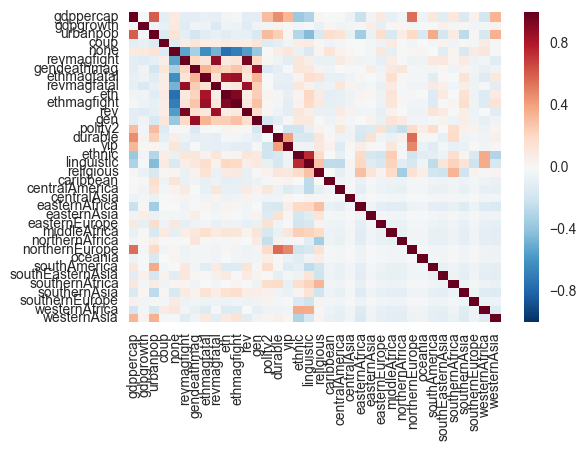

In [133]:
# Correlation map between all variables.
sns.heatmap(DF2.corr())

In [134]:
# Creating the target variable and the features.
y = DF2["coup"]
X = DF2.drop(["coup"], axis=1)

In [135]:
from sklearn.cross_validation import KFold,cross_val_score,train_test_split,cross_val_predict
from sklearn.metrics import r2_score,accuracy_score,precision_score,recall_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot

In [136]:
# Splitting the detaset into a train set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Random Forest Classifier

In [137]:
# GridSearch

# rf = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

# rfparam_grid = { 
#                 'n_estimators': [25, 50,75,100,125,150,200],
#                 'criterion': ["gini", "entropy"],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'min_samples_split':[1,2,3,4,5,6]
#                }
    
# CV_rf = GridSearchCV(estimator=rf, param_grid=rfparam_grid, cv=5)
# CV_rf.fit(X_train, y_train)
# print CV_rf.best_params_

In [138]:
# Parameters were selected based on the results from the gridsearch.
cv = KFold(len(y_train), shuffle=False) 
print cv
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features="sqrt", max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
print "Regular Random Forest scores are:", rfScore
print "Regular Random Forest average score is:", rfScore.mean()

sklearn.cross_validation.KFold(n=2097, n_folds=3, shuffle=False, random_state=None)
Regular Random Forest scores are: [ 0.93991416  0.93562232  0.94849785]
Regular Random Forest average score is: 0.941344778255


In [139]:
# Fitting the variables in the model 
rfModel = rf.fit(X_train, y_train)

In [140]:
# Using the model from the train set to predict the target for the test set.
rfPredicted = rfModel.predict(X_test)
rfProbs = rfModel.predict_proba(X_test)

In [141]:
# Creating a dataframe with actual and predicted coup results, as wel as probability of coup or no coup.
rfPredictions = pd.DataFrame()
rfPredictions["Actual"] = y_test
rfPredictions["Predicted"] = rfPredicted
rfPredictions["ProbsPos"], rfPredictions["ProbsNeg"] = zip(*rfProbs)

In [142]:
# Deriving the threshold for the highest ROC score.
newList = []
newList2 = []
for i in np.arange(0,1,0.01):
    rfPredictions["ThreshPred"] = ([0 if x < i else 1 for x in rfPredictions['ProbsNeg']])
    newList.append(roc_auc_score(rfPredictions["Actual"], rfPredictions["ThreshPred"]))
    newList2.append(i)
d = zip(newList, newList2)
max(d)

(0.74636412884943948, 0.080000000000000002)

In [143]:
# Using the threshold to predict whehther or nor a coup occurred
rfThreshold = max(d)[1]
rfPredictions["ThreshPred"] = ([0 if x < rfThreshold else 1 for x in rfPredictions['ProbsNeg']])

In [144]:
print 'accuracy score:', accuracy_score(rfPredictions["Actual"], rfPredictions["ThreshPred"])
print 'ROC Score:', roc_auc_score(rfPredictions["Actual"], rfPredictions["ThreshPred"])
print 'precision score:', precision_score(rfPredictions['Actual'],rfPredictions['ThreshPred'])
print 'recall score:', recall_score(rfPredictions['Actual'],rfPredictions['ThreshPred'])

accuracy score: 0.78531701891
ROC Score: 0.746364128849
precision score: 0.185185185185
recall score: 0.701754385965


In [145]:
# Confusion Matrix
print pd.crosstab(rfPredictions["Actual"], rfPredictions["ThreshPred"], rownames=["Actual"])

ThreshPred    0    1
Actual              
0           666  176
1            17   40


## AdaBoost Classifier

In [146]:
# GridSearch

# ab = AdaBoostClassifier() 

# abparam_grid = { 
#                 "n_estimators": [10,15,20,25,30],
#                 "learning_rate": [1.0,2.0,3.0,4.0,5.0,6.0],
#                 "algorithm": ["SAMME", "SAMME.R"]
#                }

# CV_ab= GridSearchCV(estimator=ab, param_grid=abparam_grid, cv=5)
# CV_ab.fit(X_train, y_train)
# print CV_ab.best_params_
# print CV_ab.best_estimator_

In [147]:
# Parameters were selected based on the results from the gridsearch.
cv = KFold(len(y_train), shuffle=False) 
print cv
ab = AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=2.0, n_estimators=15, random_state=20)

abScore = cross_val_score(ab, X_train, y_train, cv=cv,n_jobs=1)
print "Adaboost Decision Tree scores are:", abScore
print "Adaboost Decision Tree average score is:", abScore.mean()

sklearn.cross_validation.KFold(n=2097, n_folds=3, shuffle=False, random_state=None)
Adaboost Decision Tree scores are: [ 0.93848355  0.93562232  0.94992847]
Adaboost Decision Tree average score is: 0.941344778255


In [148]:
# Fitting the variables in the model 
abModel = ab.fit(X_train, y_train)

In [149]:
# Using the model from the train set to predict the target for the test set.
abPredicted = abModel.predict(X_test)
abProbs = abModel.predict_proba(X_test)

In [150]:
# Creating a dataframe with actual and predicted coup results, as wel as probability of coup or no coup.
abPredictions = pd.DataFrame()
abPredictions["Actual"] = y_test
abPredictions["Predicted"] = abPredicted
abPredictions["ProbsPos"], abPredictions["ProbsNeg"] = zip(*abProbs)

In [151]:
# Deriving the threshold for the highest ROC score.
newList3 = []
newList4 = []
for i in np.arange(0,1,0.01):
    abPredictions["ThreshPred"] = ([0 if x < i else 1 for x in abPredictions['ProbsNeg']])
    newList3.append(roc_auc_score(abPredictions["Actual"], abPredictions["ThreshPred"]))
    newList4.append(i)
e = zip(newList3, newList4)
max(e)

(0.66822936200358374, 0.5)

In [152]:
# Using the threshold to predict whehther or nor a coup occurred
abThreshold = max(e)[1]
abPredictions["ThreshPred"] = ([0 if x < abThreshold else 1 for x in abPredictions['ProbsNeg']])

In [153]:
print 'accuracy score:', accuracy_score(abPredictions["Actual"], abPredictions["ThreshPred"])
print 'ROC Score:', roc_auc_score(abPredictions["Actual"], abPredictions["ThreshPred"])
print 'precision score:', precision_score(abPredictions['Actual'],abPredictions['ThreshPred'])
print 'recall score:', recall_score(abPredictions['Actual'],abPredictions['ThreshPred'])

accuracy score: 0.868743047831
ROC Score: 0.668229362004
precision score: 0.225225225225
recall score: 0.438596491228


In [154]:
#Confusion Matrix
print pd.crosstab(abPredictions["Actual"], abPredictions["ThreshPred"], rownames=["Actual"])

ThreshPred    0   1
Actual             
0           756  86
1            32  25


usage:
touch [-A [-][[hh]mm]SS] [-acfhm] [-r file] [-t [[CC]YY]MMDDhhmm[.SS]] file ...


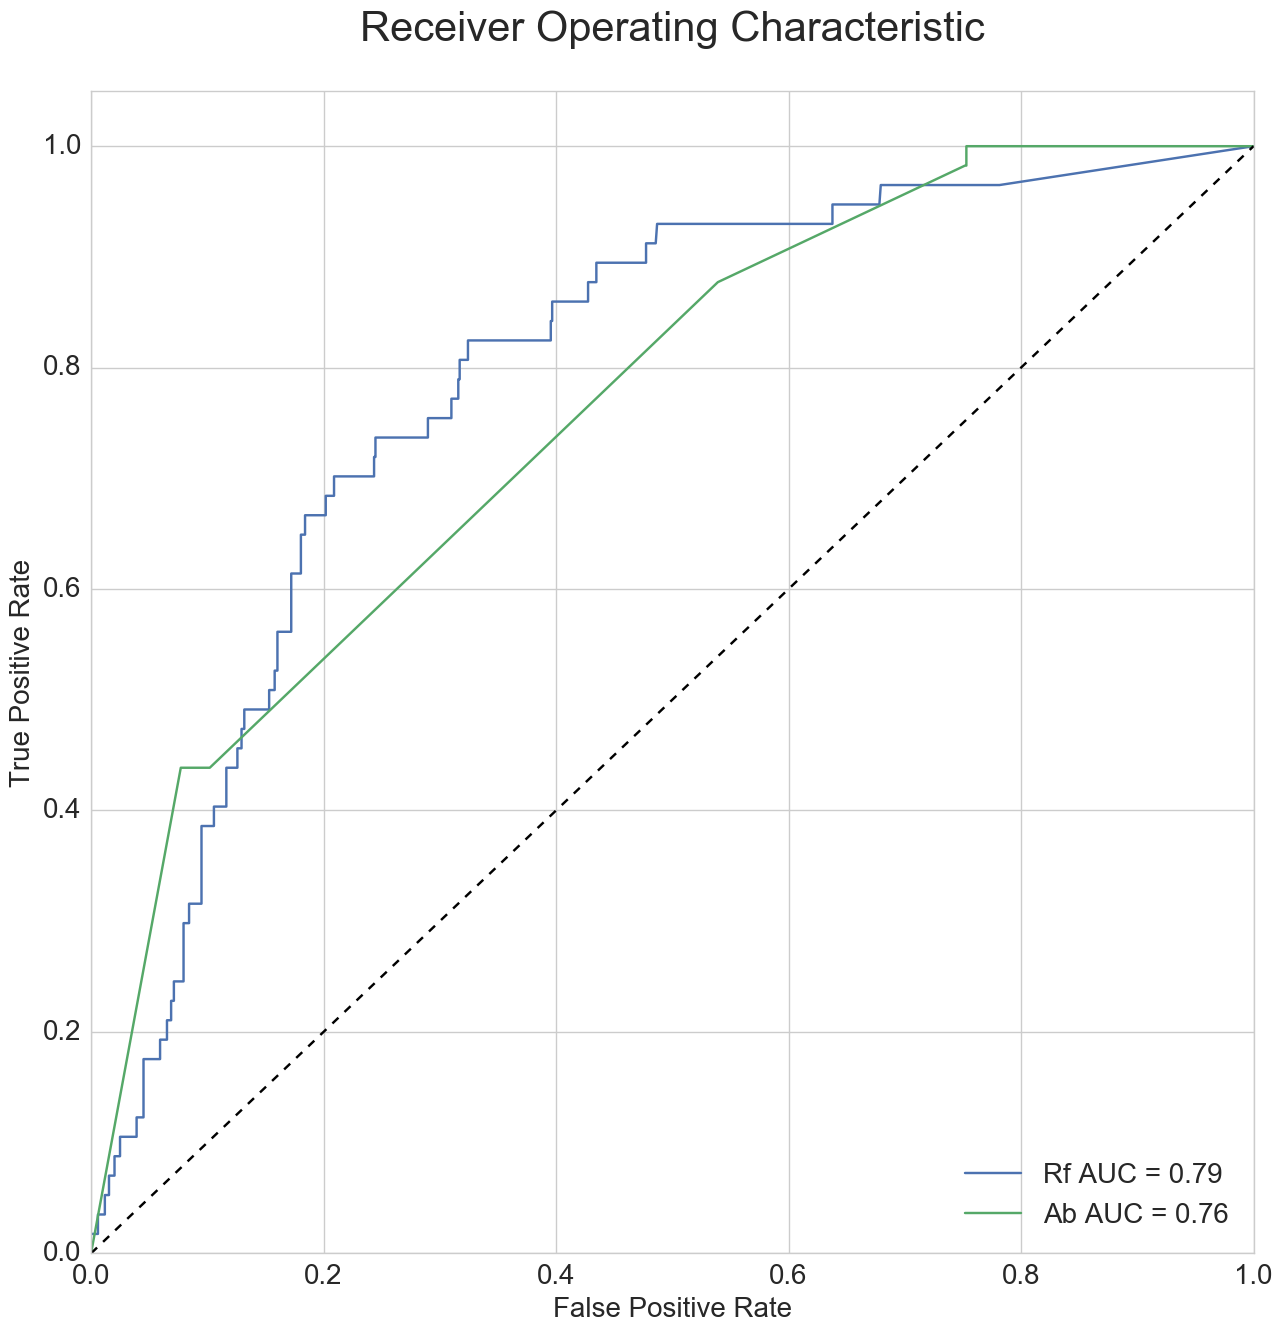

In [155]:
# Compute ROC curve and ROC area for Random Forest
rffpr = dict()
rftpr = dict()
rfroc_auc = dict()
rffpr, rftpr, _ = roc_curve(y_test, rfPredictions.ProbsNeg)
rfroc_auc = auc(rffpr, rftpr)
!touch

# Compute ROC curve and ROC area for Adaboost
abfpr = dict()
abtpr = dict()
abroc_auc = dict()
abfpr, abtpr, _ = roc_curve(y_test, abPredictions.ProbsNeg)
abroc_auc = auc(abfpr, abtpr)


# Plot of a ROC curve 
plt.figure(figsize=(15,15))
plt.plot(rffpr,rftpr,label='Rf AUC = %0.2f' % rfroc_auc)
plt.plot(abfpr,abtpr,label='Ab AUC = %0.2f' % abroc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic\n', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()

## Random Forest with Feature Selection - Robustness

In [156]:
# Averaging feature importances across trees in random forest model.
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ]),
 <a list of 6 Text yticklabel objects>)

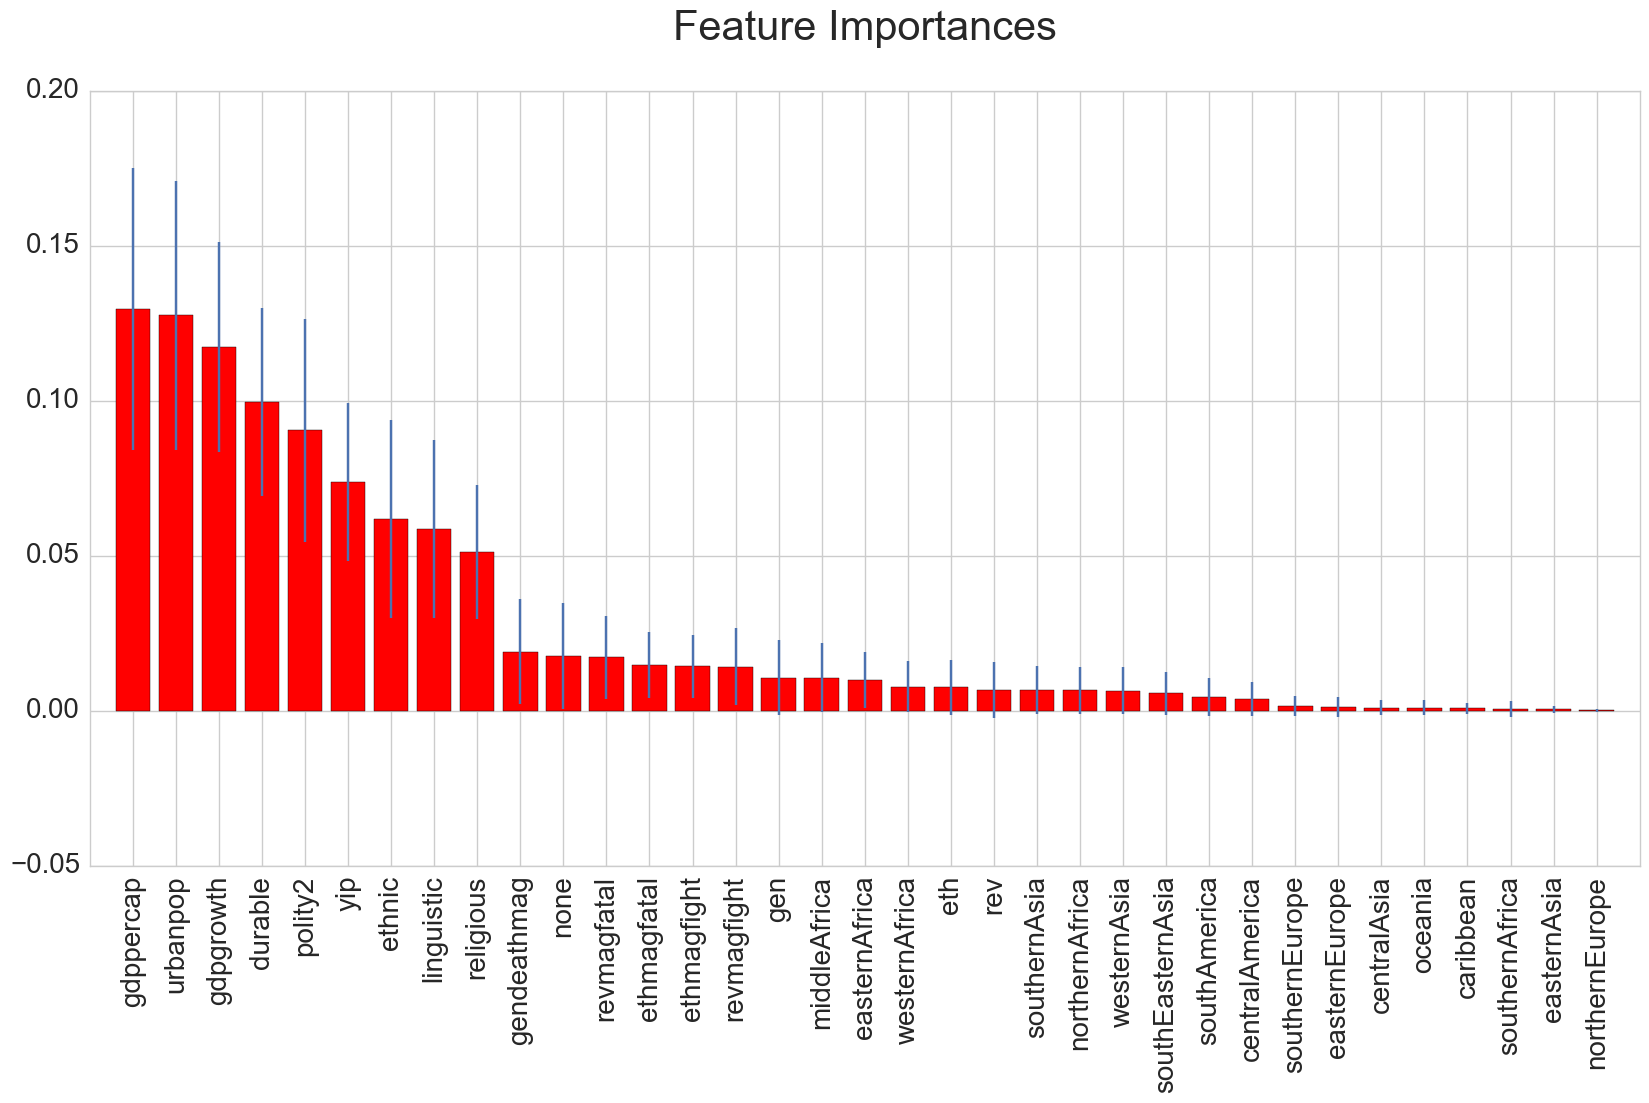

In [157]:
# Graph displaying feature importance.
plt.figure(figsize=(20,10))
plt.title("Feature Importances\n", fontsize = 30)
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90, fontsize = 20)
plt.xlim([-1, X_train.shape[1]])
plt.yticks(fontsize=20)

In [158]:
# New X variables based on feature importance.
X_new = DF2[["gdppercap", "urbanpop", "gdpgrowth", "durable", "yip",
            "polity2", "ethnic", "religious", "linguistic"]]

In [159]:
# Splitting the dataset.
X_newtrain, X_newtest, y_newtrain, y_newtest = train_test_split(X_new, y, test_size=0.3, random_state=0)

In [160]:
# Grid Search

# rf2 = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=100, oob_score = True) 

# rf2param_grid = { 
#                 'n_estimators': [50,75,100,125,150],
#                 'criterion': ["gini", "entropy"],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'min_samples_split':[1,2,3,4,5,6]
#                 }
    
# CV_rf2 = GridSearchCV(estimator=rf2, param_grid=rf2param_grid, cv=5)
# CV_rf2.fit(X_newtrain, y_newtrain)
# print CV_rf2.best_params_

In [161]:
# Parameters were selected based on the results from the gridsearch.
cv2 = KFold(len(y_newtrain), shuffle=False) 
print cv2
rf2 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features="sqrt", max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=True, random_state=20, verbose=0, warm_start=False)
rfScore = cross_val_score(rf, X_train, y_train, cv=cv, n_jobs=-1)
print "Regular Decision Tree scores are:", rfScore
print "Regular Decision Tree average score is:", rfScore.mean()

sklearn.cross_validation.KFold(n=2097, n_folds=3, shuffle=False, random_state=None)
Regular Decision Tree scores are: [ 0.93991416  0.93562232  0.94849785]
Regular Decision Tree average score is: 0.941344778255


In [162]:
# Fitting the variables in the model. 
rf2Model = rf2.fit(X_newtrain, y_newtrain)

In [163]:
# Using the model from the train set to predict the target for the test set.
rf2Predicted = rf2Model.predict(X_newtest)
rf2Probs = rf2Model.predict_proba(X_newtest)

In [164]:
# Creating a dataframe with actual and predicted coup results, as wel as probability of coup or no coup.
rf2Predictions = pd.DataFrame()
rf2Predictions["Actual"] = y_newtest
rf2Predictions["Predicted"] = rf2Predicted
rf2Predictions["ProbsPos"], rf2Predictions["ProbsNeg"] = zip(*rf2Probs)

In [165]:
# Deriving the threshold for the highest ROC score.
newList5 = []
newList6 = []
for i in np.arange(0,1,0.01):
    rf2Predictions["ThreshPred"] = ([0 if x < i else 1 for x in rf2Predictions['ProbsNeg']])
    newList5.append(roc_auc_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"]))
    newList6.append(i)
f = zip(newList5, newList6)
max(f)

(0.73764428886944211, 0.059999999999999998)

In [166]:
# Using the threshold to predict whehther or nor a coup occurred
rf2Threshold = max(f)[1]
rf2Predictions["ThreshPred"] = [0 if x < rf2Threshold else 1 for x in rf2Predictions['ProbsNeg']]

In [167]:
print 'accuracy score:', accuracy_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"])
print 'ROC Score:', roc_auc_score(rf2Predictions["Actual"], rf2Predictions["ThreshPred"])
print 'precision score:', precision_score(rf2Predictions['Actual'],rf2Predictions['ThreshPred'])
print 'recall score:', recall_score(rf2Predictions['Actual'],rf2Predictions['ThreshPred'])

accuracy score: 0.723025583982
ROC Score: 0.737644288869
precision score: 0.154676258993
recall score: 0.754385964912


In [168]:
# Confusion Matrix
print pd.crosstab(rf2Predictions["Actual"], rf2Predictions["ThreshPred"], rownames=["Actual"])

ThreshPred    0    1
Actual              
0           607  235
1            14   43


## AdaBoost with Feature Selection - Robustness

In [169]:
# Grid Search

# ab2 = AdaBoostClassifier() 

# ab2param_grid = { 
#                 "n_estimators": [10,15,20,25,30],
#                 "learning_rate": [1.0,2.0,3.0,4.0,5.0,6.0],
#                 "algorithm": ["SAMME", "SAMME.R"]
#                }

# CV_ab2= GridSearchCV(estimator=ab2, param_grid=ab2param_grid, cv=5)
# CV_ab2.fit(X_newtrain, y_newtrain)
# print CV_ab2.best_params_
# print CV_ab2.best_estimator_

In [170]:
# Parameters were selected based on the results from the gridsearch.
cv = KFold(len(y_train), shuffle=False) 
print cv
ab2 = AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=1.0, n_estimators=20, random_state=20)

ab2Score = cross_val_score(ab2, X_newtrain, y_newtrain, cv=cv,n_jobs=1)
print "Adaboost Decision Tree scores are:", ab2Score
print "Adaboost Decision Tree average score is:", ab2Score.mean()

sklearn.cross_validation.KFold(n=2097, n_folds=3, shuffle=False, random_state=None)
Adaboost Decision Tree scores are: [ 0.93991416  0.93562232  0.94277539]
Adaboost Decision Tree average score is: 0.939437291369


In [171]:
# Fitting the variables in the model. 
ab2Model = ab2.fit(X_newtrain, y_newtrain)

In [172]:
# Using the model from the train set to predict the target for the test set.
ab2Predicted = ab2Model.predict(X_newtest)
ab2Probs = ab2Model.predict_proba(X_newtest)

In [173]:
# Creating a dataframe with actual and predicted coup results, as wel as probability of coup or no coup.
ab2Predictions = pd.DataFrame()
ab2Predictions["Actual"] = y_newtest
ab2Predictions["Predicted"] = ab2Predicted
ab2Predictions["ProbsPos"], ab2Predictions["ProbsNeg"] = zip(*ab2Probs)

In [174]:
# Deriving the threshold for the highest ROC score.
newList7 = []
newList8 = []
for i in np.arange(0,1,0.01):
    ab2Predictions["ThreshPred"] = ([0 if x < i else 1 for x in ab2Predictions['ProbsNeg']])
    newList7.append(roc_auc_score(ab2Predictions["Actual"], ab2Predictions["ThreshPred"]))
    newList8.append(i)
g = zip(newList7, newList8)
max(g)

(0.71794390965537358, 0.41999999999999998)

In [175]:
# Using the threshold to predict whehther or nor a coup occurred
ab2Threshold = max(g)[1]
ab2Predictions["ThreshPred"] = ([0 if x < ab2Threshold else 1 for x in ab2Predictions['ProbsNeg']])

In [176]:
print 'accuracy score:', accuracy_score(ab2Predictions["Actual"], ab2Predictions["ThreshPred"])
print 'ROC Score:', roc_auc_score(ab2Predictions["Actual"], ab2Predictions["ThreshPred"])
print 'precision score:', precision_score(ab2Predictions['Actual'],ab2Predictions['ThreshPred'])
print 'recall score:', recall_score(ab2Predictions['Actual'],ab2Predictions['ThreshPred'])

accuracy score: 0.808676307008
ROC Score: 0.717943909655
precision score: 0.189189189189
recall score: 0.614035087719


In [177]:
# Confusion Matrix
print pd.crosstab(ab2Predictions["Actual"], ab2Predictions["ThreshPred"], rownames=["Actual"])

ThreshPred    0    1
Actual              
0           692  150
1            22   35


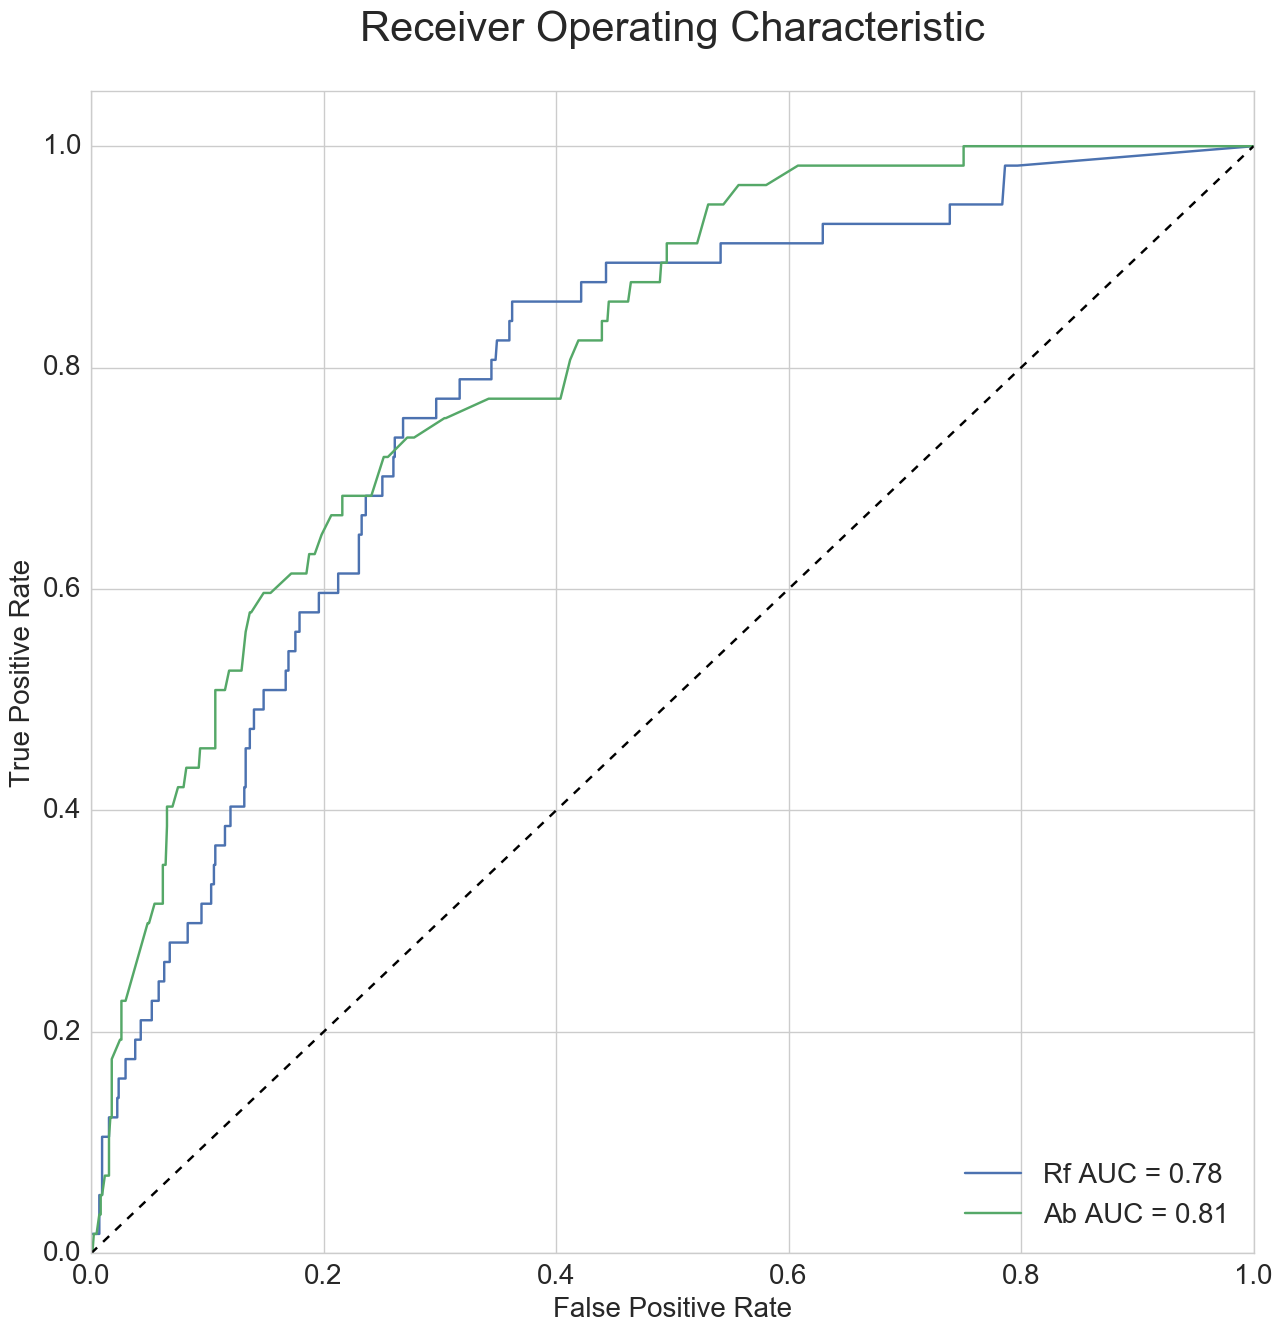

In [178]:
# Add by Beau t
# import tablib
import sys

# Compute ROC curve and ROC area for Random Forest (with feature selection)
rffpr2 = dict()
rftpr2 = dict()
rfroc_auc2 = dict()
rffpr2, rftpr2, _ = roc_curve(y_newtest, rf2Predictions.ProbsNeg)
rfroc_auc2 = auc(rffpr2, rftpr2)

# Compute ROC curve and ROC area for Adaboost
abfpr2 = dict()
abtpr2 = dict()
abroc_auc2 = dict()
abfpr2, abtpr2, _ = roc_curve(y_newtest, ab2Predictions.ProbsNeg)
abroc_auc2 = auc(abfpr2, abtpr2)

# Plot of a ROC curve 
plt.figure(figsize=(15,15))
plt.plot(rffpr2,rftpr2,label='Rf AUC = %0.2f' % rfroc_auc2)
plt.plot(abfpr2,abtpr2,label='Ab AUC = %0.2f' % abroc_auc2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('Receiver Operating Characteristic\n', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.show()


# Function to save charts to images. Need to export data from ROC Curve plt above to a data source usable with D3.JS
# fig.savefig('fig.png')

# print(rffpr2)


## Logistic Regression

In [179]:
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
# import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

In [180]:
y1, X1 = dmatrices("coup ~ gdppercap + gdpgrowth + urbanpop + none + \
                    revmagfight + gendeathmag + ethmagfatal + revmagfatal + \
                    eth + ethmagfight + rev + gen + polity2 + durable + yip + \
                    ethnic + linguistic + religious + caribbean + centralAmerica + \
                    centralAsia + easternAfrica + easternAsia + easternEurope + \
                    middleAfrica + northernAfrica + northernEurope + oceania + southAmerica + \
                    southEasternAsia + southernAfrica + southernAsia + southernEurope + \
                    westernAfrica", DF2, return_type="dataframe")

In [181]:
y1 = np.ravel(y1)

In [182]:
lr = LogisticRegression()
lrModel = lr.fit(X1,y1)

In [183]:
coeffName =  X1.columns.tolist()
coeff =  lrModel.coef_[0]
coeffs = pd.DataFrame(zip(coeffName, coeff), columns=["CoeffName", "Coeff"])
coeffs.head()

,CoeffName,Coeff
0,Intercept,-0.555891
1,gdppercap,-0.000137
2,gdpgrowth,-0.031287
3,urbanpop,-0.007579
4,none,-0.850021


In [184]:
X_norm =  StandardScaler().fit_transform(X1)

lrModel2 = lr.fit(X_norm, y1)
coeff2 = lrModel2.coef_[0]
coeffs2 = pd.DataFrame(zip(coeffName, coeff2), columns=["CoeffName", "Coeff"])
coeffs3 = coeffs2
coeffs3["Coeff"] = abs(coeffs3["Coeff"])
coeffs3.sort("Coeff", ascending = False, inplace=True)

/Users/airbr/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [185]:
y2, X2 = dmatrices("coup ~ gdpgrowth + urbanpop + none + \
                     durable + polity2 + gdppercap + ethnic + \
                     linguistic + caribbean + easternAfrica + \
                     easternAsia + easternEurope + southernAfrica + \
                     southernAsia", DF2, return_type="dataframe")

In [186]:
y2 = np.ravel(y2)

In [187]:
lrModel2 = lr.fit(X2, y2)
# logit = sm.Logit(X2, y2)
# result = logit.fit()
# result.summary()
lrModel2.coef_

array([[ -5.93989926e-01,  -3.14023207e-02,  -1.05946582e-02,
         -7.24488868e-01,  -3.04021837e-02,  -9.31878974e-02,
         -1.54635793e-04,  -1.16311308e-01,   2.00799406e-01,
         -2.44749674e-01,  -8.94954000e-01,  -2.47435653e-01,
         -3.51631106e-01,  -7.68893844e-02,  -4.01771909e-01]])

In [188]:
coeffName2 =  X2.columns.tolist()
coeff2 =  np.exp(lrModel2.coef_[0])
coeffs2 = pd.DataFrame(zip(coeffName2, coeff2), columns=["CoeffName", "Coeff"])
coeffs2

,CoeffName,Coeff
0,Intercept,0.552120
1,gdpgrowth,0.969086
2,urbanpop,0.989461
3,none,0.484572
4,durable,0.970055
5,polity2,0.911022
6,gdppercap,0.999845
7,ethnic,0.890198
8,linguistic,1.222380
9,caribbean,0.782900
